# 人脸检测和识别训练流程

以下示例展示了如何在自己的数据集上微调InceptionResnetV1模型。这将主要遵循标准的PyTorch训练模式。

In [8]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

#### 定义运行参数

数据集应该遵循VGGFace2/ImageNet风格的目录布局。将`data_dir`修改为您要微调的数据集所在的位置。

In [9]:
data_dir = '../data/test_images'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

#### 判断是否有nvidia GPU可用

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('在该设备上运行: {}'.format(device))

在该设备上运行: cpu


#### 定义MTCNN模块

查看`help(MTCNN)`获取更多细节。

facenet_pytorch.MTCNN是一个用于人脸检测和对齐的Python库。它使用了三个级联的神经网络来完成这个任务，分别是P-Net、R-Net和O-Net。

在MTCNN中，有三个阈值需要设置，分别是人脸检测的阈值、人脸对齐的阈值和人脸裁剪的阈值。

人脸检测的阈值（detection_threshold）：用于确定是否存在人脸的阈值，默认值为0.6。当检测到的人脸置信度大于该阈值时，认为存在人脸。

人脸对齐的阈值（landmarks_threshold）：用于确定是否成功对齐人脸的阈值，默认值为0.7。当对齐后的人脸关键点置信度大于该阈值时，认为对齐成功。

人脸裁剪的阈值（min_face_size）：用于确定最小人脸尺寸的阈值，默认值为20。当检测到的人脸尺寸小于该阈值时，将被忽略。

这些阈值可以根据具体应用场景进行调整，以达到更好的检测和对齐效果。

In [70]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

facenet_pytorch.MTCNN是一个用于人脸检测和对齐的模型，它有以下几个参数：

min_face_size：最小人脸尺寸。默认值为20，表示检测到的人脸的最小边长为20个像素。

thresholds：阈值列表。默认值为[0.6, 0.7, 0.7]，表示在三个不同的阈值下进行人脸检测和对齐。

factor：图像金字塔的缩放因子。默认值为0.709，用于生成不同尺度的图像。

post_process：是否进行后处理。默认值为True，表示进行后处理以去除重叠的人脸框。

device：设备类型。默认值为"cuda:0"，表示使用GPU进行计算。如果没有可用的GPU，则可以设置为"cpu"。

keep_all：是否保留所有检测到的人脸框。默认值为False，表示只保留最大的人脸框。

select_largest：是否选择最大的人脸框。默认值为False，表示选择所有检测到的人脸框。

prewhiten：是否对图像进行预白化处理。默认值为True，表示对图像进行预处理以提高模型性能。

#### 执行MTCNN人脸检测

迭代DataLoader对象并获取裁剪后的人脸。

Dataset ImageFolder
    Number of datapoints: 5
    Root location: ../data/test_images
    StandardTransform
Transform: Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
5
[('../data/test_images\\angelina_jolie\\1.jpg', 0), ('../data/test_images\\bradley_cooper\\1.jpg', 1), ('../data/test_images\\kate_siegel\\1.jpg', 2), ('../data/test_images\\paul_rudd\\1.jpg', 3), ('../data/test_images\\shea_whigham\\1.jpg', 4)]
<PIL.Image.Image image mode=RGB size=512x512 at 0x1F64F313D70>
0


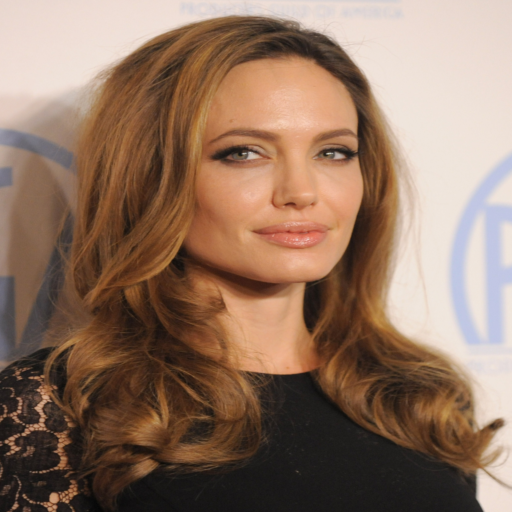

../data/test_images\angelina_jolie\1.jpg
0
../data/test_images\angelina_jolie\1.jpg
../data/test_images_cropped\angelina_jolie\1.jpg
['../data/test_images_cropped\\angelina_jolie\\1.jpg', '../data/test_images_cropped\\bradley_cooper\\1.jpg', '../data/test_images_cropped\\kate_siegel\\1.jpg', '../data/test_images_cropped\\paul_rudd\\1.jpg', '../data/test_images_cropped\\shea_whigham\\1.jpg']


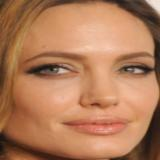

第 1 批，共 1 批

In [76]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

from IPython import display

dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
print(dataset)
print(len(dataset))
print(dataset.samples)
print(dataset[0][0])
print(dataset[0][1])
display.display(dataset[0][0])
print(dataset.samples[0][0])
print(dataset.samples[0][1])
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
print(dataset.samples[0][0])
print(dataset.samples[0][1])
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    display.display(display.Image(y[0]))
    print('\r第 {} 批，共 {} 批'.format(i + 1, len(loader)), end='')

# Remove mtcnn to reduce GPU memory usage
del mtcnn

# help(datasets.ImageFolder)

#### 定义Inception Resnet V1模块

查看`help(InceptionResnetV1)`获取更多细节。

In [83]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

#### 定义优化器、调度器、数据集和数据加载器

In [79]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

#### 定义损失和评估函数

In [80]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

#### 训练模型

In [81]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\n初始化')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\n循环 {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



初始化
----------
Valid |     1/1    | loss:    1.3435 | fps:    0.0090 | acc:    1.0000   

循环 1/8
----------
Train |     1/1    | loss:    1.7025 | fps:    8.3691 | acc:    0.2500   
Valid |     1/1    | loss:    2.9671 | fps:   19.3191 | acc:    0.0000   

循环 2/8
----------
Train |     1/1    | loss:    0.1740 | fps:    8.6546 | acc:    1.0000   
Valid |     1/1    | loss:    4.4394 | fps:   17.8783 | acc:    0.0000   

循环 3/8
----------
Train |     1/1    | loss:    0.0283 | fps:    9.4959 | acc:    1.0000   
Valid |     1/1    | loss:    6.1855 | fps:   15.8395 | acc:    0.0000   

循环 4/8
----------
Train |     1/1    | loss:    0.0068 | fps:    7.8953 | acc:    1.0000   
Valid |     1/1    | loss:    7.6332 | fps:   33.4330 | acc:    0.0000   

循环 5/8
----------
Train |     1/1    | loss:    0.0025 | fps:    8.2179 | acc:    1.0000   
Valid |     1/1    | loss:    7.2395 | fps:   21.2642 | acc:    0.0000   

循环 6/8
----------
Train |     1/1    | loss:    0.0011 | fps:    8.9632 |